In [ ]:
%pip install --upgrade gpudb==7.2.0.1 pandas pyarrow typeguard langchain langchain_openai nemollm colorlog langchain-community

In [1]:
import gpudb

db = gpudb.GPUdb(host='https://demo72.kinetica.com/_gpudb',
                     username='gtc',
                     password='Kinetica123!')

# We want to have our own individual context to work with, so create an extension to the context name as shown here
extension = 'aaron'

sqlcontext = f'''CREATE OR REPLACE CONTEXT nyse.nyse_report_ctxt_{extension}
(
    TABLE = nyse.prices,
    COMMENT = 'Stock prices including ask, bid, and sale price and size',
    RULES = (
        'when I ask about stock prices, use the nyse.prices table',
        'when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day',
        'all stock symbols are in lower case',
        'when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day',
        'when I ask about any column, make sure there are no null values or NaN values',
        'replace all NaN values with 0 using the IFNAN() function',
        'all numeric results should be larger than 0',
        'convert all stock symbols to lower case',
        'always filter out null values'
    ),
    COMMENTS = (
        'ap' = 'ask price',
        'bp' = 'bid price',
        'bs' = 'bid size',
        'lp' = 'sale price',
        'ls' = 'sale size',
        's' = 'symbol',
        't' = 'timestamp'
    )
),
(
    TABLE = nyse.vector_week,
    COMMENT = 'Time-series vector embeddings for NYSE stock characteristics spanning 1 week intervals'
),
(
    SAMPLES = (
'find similar patterns to tsco for the previous week' = 'SELECT
    ts_bkt,
    symbol,
    l1_distance(ap_vec,(select string(ap_vec) from (select * from nyse.vector_week where ts_bkt = date_trunc(week, now() - interval 1 week) and symbol = ''tsco'' limit 1))) as d1
FROM
    (select * from nyse.vector_week where ts_bkt = date_trunc(week, now() - interval 1 week)) filtered
ORDER BY
    d1 asc
LIMIT
    5;',
'Show me a top 5 list of stocks from today whose value increased by at least 12%' = 'SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) AS price_increase_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekly) AS PriceChanges
WHERE
    price_increase_percentage > 12
ORDER BY
    price_increase_percentage desc
LIMIT 5;',
'Show me a top 5 list of stocks from today whose value decreased by at least 12%' = 'SELECT
    s,
    price_decrease_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) * -1 AS price_decrease_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekly) AS PriceChanges
WHERE
    price_decrease_percentage > 12
ORDER BY
    price_decrease_percentage desc
LIMIT 5;'
    )
)
    '''
db.execute_sql(sqlcontext)

{'count_affected': 1,
 'response_schema_str': '{"name":"generic_response","type":"record","fields":[{"name":"column_1","type":{"type":"array","items":"string"}},{"name":"column_headers","type":{"type":"array","items":"string"}},{"name":"column_datatypes","type":{"type":"array","items":"string"}}]}',
 'binary_encoded_response': b'\x00\x02\ndummy\x00\x02\x0cstring\x00',
 'json_encoded_response': '',
 'total_number_of_records': -1,
 'has_more_records': False,
 'paging_table': '',
 'info': {'X-Kinetica-Group': 'DDL',
  'count': '0',
  'last_endpoint': '/create/context/internal',
  'total_number_of_records': '0'},
 'status_info': {'status': 'OK',
  'message': '',
  'data_type': 'execute_sql_response',
  'response_time': 0.02242},
 'record_type': kinetica.protocol.RecordType('', [('dummy', 'string')])}

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.kinetica import ChatKinetica, KineticaSqlOutputParser, KineticaSqlResponse, KineticaUtil
from IPython.display import display, HTML

# create the Kinetica connection
kdbc = KineticaUtil.create_kdbc(url="https://demo72.kinetica.com/_gpudb", user="gtc", passwd="Kinetica123!")

# create the Kinetica LLM
kinetica_llm = ChatKinetica(kdbc=kdbc)

# Set the context to use
kinetica_ctx = f'nyse.nyse_report_ctxt_{extension}'

In [3]:
# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)

================================ System Message ================================

CREATE TABLE nyse.prices AS
(
   t DATETIME NOT NULL COMMENT 'timestamp',
   s VARCHAR (8, dict, shard_key) NOT NULL COMMENT 'symbol',
   type VARCHAR (4, dict) NOT NULL,
   ap REAL  COMMENT 'ask price',
   as INTEGER,
   bp REAL  COMMENT 'bid price',
   bs INTEGER  COMMENT 'bid size',
   lp REAL  COMMENT 'sale price',
   ls INTEGER  COMMENT 'sale size'
);
COMMENT ON TABLE nyse.prices IS 'Stock prices including ask, bid, and sale price and size';
-- When querying table nyse.prices the following rules apply:
-- * when I ask about stock prices, use the nyse.prices table
-- * when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day
-- * all stock symbols are in lower case
-- * when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day
-- * when I ask about any column, make sure there are no null value

In [4]:
response: KineticaSqlResponse = chain.invoke({"input": '''show me a sample of the vector data'''})
display(HTML(response.dataframe.to_html(index=False)))

ts_bkt,symbol,ap_vec
2023-06-11,a,"[33.410133, 0.02206052, 1.0, 0.37085402, 124.21324, 5.111166, -0.11861205, -0.3599464, -0.124307394, 3.0, 57.0, 1.5692475, 0.0625, 0.14285715, 0.24489796, 0.7983316, 0.05522331, 0.0011261262, 0.62419564, 2.0, 0.10048193, 17.0]"
2023-06-11,aaau,"[0.7810719, -2.1616833, 1.0, 0.0046902806, 19.233261, 1.8405352, -0.9047696, -0.37448904, 0.9782609, 2.0, 541.0, 0.47646618, 0.25454745, 0.8695652, 0.2826087, 0.37138253, 1.2640002, 0.14285715, 1.0096765, 4.0, 0.012704174, 3.0]"
2023-06-11,aac,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2023-06-11,aaci,"[0.356142, -0.015358071, 1.0, 0.16105165, 5.1857295, 5.1913137, 0.0017857782, 0.0017857782, 0.0042918455, 3.0, 3.0, 1.7161372, 0.03844606, 0.82608694, 0.5, 0.00365985, 3.1415927, 1.0, 1.2915943, 1.0, 0.88817203, 3.0]"
2023-06-11,aact+,"[0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


<Axes: xlabel='t'>

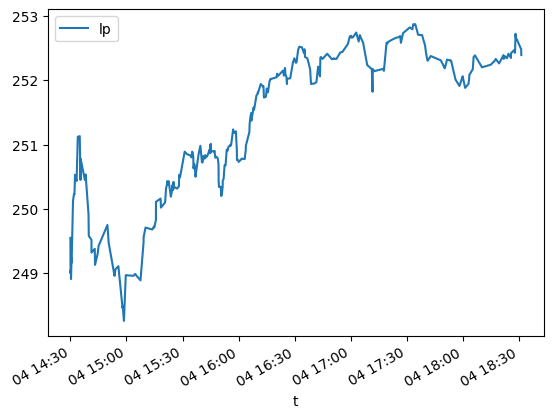

In [5]:
response: KineticaSqlResponse = chain.invoke({"input": '''show me all sale prices for tsco for the last week where the sale price is recorded'''})
response.dataframe.plot.line(x='t', y='lp')

In [6]:
import importlib
import kinetica.kineai_summarize

importlib.reload(kinetica.kineai_summarize)
kineticallm = kinetica.kineai_summarize.KineticaLLM(f'nyse.nyse_report_ctxt_{extension}')

In [40]:
system = """ KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica
LLM is designed to translate natural language questions into SQL queries. 

The SqlAssist AI will respond with an answer to the question in JSON format from SqlAssist.

Your job is to summarize multiple result sets in JSON form into a report suitable for a financial executive

when presented with stock symbols and prices, you should summarize them as a bulleted list
"""
#firt 4 pair hwo to call Kinetika (this )
# Ilustrate this better where you have a bigger paragraph
# Have the content asnwer. 
context0 = [dict(role="system", content=system),
            dict(role='user', content='''TOP 5 Gains

[{"s": "aapl", "price_increase_percentage": 11226.1162109375}, {"s": "tgl", "price_increase_percentage": 6417.857421875}, {"s": "egio", "price_increase_percentage": 4299.8212890625}, {"s": "cjjd", "price_increase_percentage": 1689.0771484375}, {"s": "celu", "price_increase_percentage": 881.7233276367188}]

TOP 5 Losses

[{"s": "tsla", "price_decrease_percentage": 36.486488342285156}, {"s": "shotw", "price_decrease_percentage": 31.249996185302734}, {"s": "qbts+", "price_decrease_percentage": 30.000001907348633}, {"s": "lidrw", "price_decrease_percentage": 25.0}, {"s": "evlvw", "price_decrease_percentage": 19.169803619384766}]'''),
            dict(role='assistant', content='''
            Top 5 gains:
                - aapl up 11226.1162109375%
                - tgl up 6435.08740234375%
                - egio up 4299.8212890625%
                - cjjd up 1689.0771484375%
                - celu up 881.7233276367188%
            Top 5 losses:
                - tsla down 36.486488342285156%
                - shotw down 25.0%
                - qbts+ down 17.329906463623047%
                - lidrw down 16.92306900024414%
                - evlvw down 16.465866088867188%
            ''')]

In [8]:
question = 'show me the top 5 stocks that have increased in value by 12% or more in the last week with percentage increases'
out_ctxt = kineticallm.chat(context0, question)
display(out_ctxt)


s,price_increase_percentage
phun,11226.116211
tgl,6417.857422
egio,4299.821289
cjjd,1689.077148
celu,881.723328


In [9]:
question = 'show me the top 5 stocks that have decreased in value by 12% or more in the last week with percentage decreases'
out_ctxt = kineticallm.chat(context0, question)
display(out_ctxt)

s,price_decrease_percentage
lgvcw,36.486488
lidrw,25.000000
conxw,17.329906
lqr,16.923069
astr,16.465866


In [41]:
percentage_change = 5
out_ctxt = kineticallm.report(context0, percentage_change)
print(out_ctxt)

INFO:SqlAssistLLM:Query: show me the top 5 stocks that have increased in value by 5% or more in the last week with percentage increases
INFO:SqlAssistLLM:SQL: SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) AS price_increase_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekly

The following JSON is a summary of the stock market performance for the top 5 gainers and losers. The top 5 gainers are:

- phun up 11226.1162109375%
- tgl up 6417.857421875%
- egio up 4299.8212890625%
- auud up 2006.25%
- cjjd up 1689.0771484375%

The top 5 losers are:

- lgvcw down 36.486488342285156%
- shotw down 31.249996185302734%
- qbts+ down 30.000001907348633%
- lidrw down 25.0%
- evlvw down 19.169803619384766%
